<a href="https://colab.research.google.com/github/AshishRaj04/backpropagation-and-neural-network-implementation-from-scratch/blob/main/Multilayer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building out a neural network library

## Importing necessary libraries

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Defining the `Value` class

In [ ]:
class Value():
  def __init__(self , data , _children=() , _op = "" , _label = ""):
    self.data = data
    self._backward = lambda: None
    self._prev = set(_children)
    self.grad = 0
    self._op = _op
    self._label = _label
  def __repr__(self):
    return f"Value(data={self.data})"
  def __add__(self,other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data + other.data , (self , other) , "+")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  def __mul__(self,other): # a.__mul__(b)
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data * other.data , (self , other) , "*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  def __sub__(self , other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data - other.data , (self , other) , "-")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += -1.0 * out.grad
    out._backward = _backward
    return out
  def __truediv__(self , other):
    other = other if isinstance(other , Value) else Value(other)
    out = Value(self.data / other.data , (self , other) , "/")
    def _backward():
      self.grad += 1.0 / other.data * out.grad
      other.grad += -self.data / other.data**2 * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __radd__(self , other):
    return self + other

  def __neg__(self):
    return self * -1

  def tanh(self):
       x = self.data
       t = (np.exp(2*x)-1)/(np.exp(2*x)+1)
       out = Value(t , (self ,) , 'tanh')
       def _backward():
         self.grad += (1-t**2) * out.grad
       out._backward = _backward
       return out

  def exp(self):
    x = self.data
    out = Value(np.exp(x) , (self , ) , 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def pow(self,other):
    assert isinstance(other , (int,float))
    x = self.data
    out = Value(x**other , (self , ) , f'**{other}')
    def _backward():
      self.grad += other * x**(other - 1) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    stack = []
    visited = set()

    def dfs(node):
      if node  in visited:
        return
      visited.add(node)
      for child in node._prev:
        dfs(child)
      stack.append(node)

    dfs(self)
    self.grad = 1.0
    for node in stack[::-1]:
      node._backward()



## Defining the `Neuron`, `Layer`, and `MLP` classes
This cell defines the core components of the neural network:
- `Neuron`: Represents a single neuron in the network, with weights, bias, and an activation function.
- `Layer`: A collection of neurons forming a layer in the network.
- `MLP`: The Multilayer Perceptron, consisting of multiple layers stacked together.


In [ ]:
class Neuron():
  def __init__(self , nin):
    self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(np.random.uniform(-1,1))

  def __call__(self,x): # The __call__ method in Python allows an instance of a class to be called like a function. This means that if a class defines __call__, its objects can be used as functions.
    z = sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
    out = z.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer():
  def __init__(self , nin , nout):
   self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self ,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP():
  def __init__(self , nin , nouts):
    sz = [nin] + nouts # [3] + [4,4,1] = [3, 4, 4, 1]
    self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

  def __call__(self , x):
      for layer in self.layers:
        x = layer(x)
      return x

  def parameters(self):
    params = []
    for layer in self.layers:
      ps = layer.parameters()
      params.extend(ps)
    return params





## Instantiating and using the `MLP`
This cell creates an instance of the `MLP` class with specified input and output dimensions.
It then passes input data through the network to obtain the output.

In [ ]:
x  = [2.0 , 3.0 , -1.0]
a = MLP(3 , [4,4,1])
a(x)

Value(data=-0.9303503586633305)

In [ ]:
from graphviz import Digraph
from IPython.display import display

def draw_computation_graph(root):
    """Generates a Graphviz computation graph and displays it."""
    dot = Digraph(format='png', graph_attr={'rankdir': 'TB'})  # Top to Bottom layout

    def add_nodes_edges(node):
        """Recursive function to add nodes and edges."""
        if node not in visited:
            visited.add(node)
            node_id = str(id(node))

            # Node label with operation if applicable
            label = f"data: {node.data:.2f} |\n label: {node._label} | \n grad: {node.grad:.4f}"
            if node._op:
                label = f"oper: {node._op} | \n value: {node.data:.2f} | \n label: {node._label} | \n grad: {node.grad:.4f}"
            dot.node(node_id, label, shape="record", style="filled", fillcolor="lightblue")

            # Add edges for previous nodes
            for child in node._prev:
                child_id = str(id(child))
                dot.edge(child_id, node_id)
                add_nodes_edges(child)

    visited = set()
    add_nodes_edges(root)
    return dot

## Visualizing the computation graph

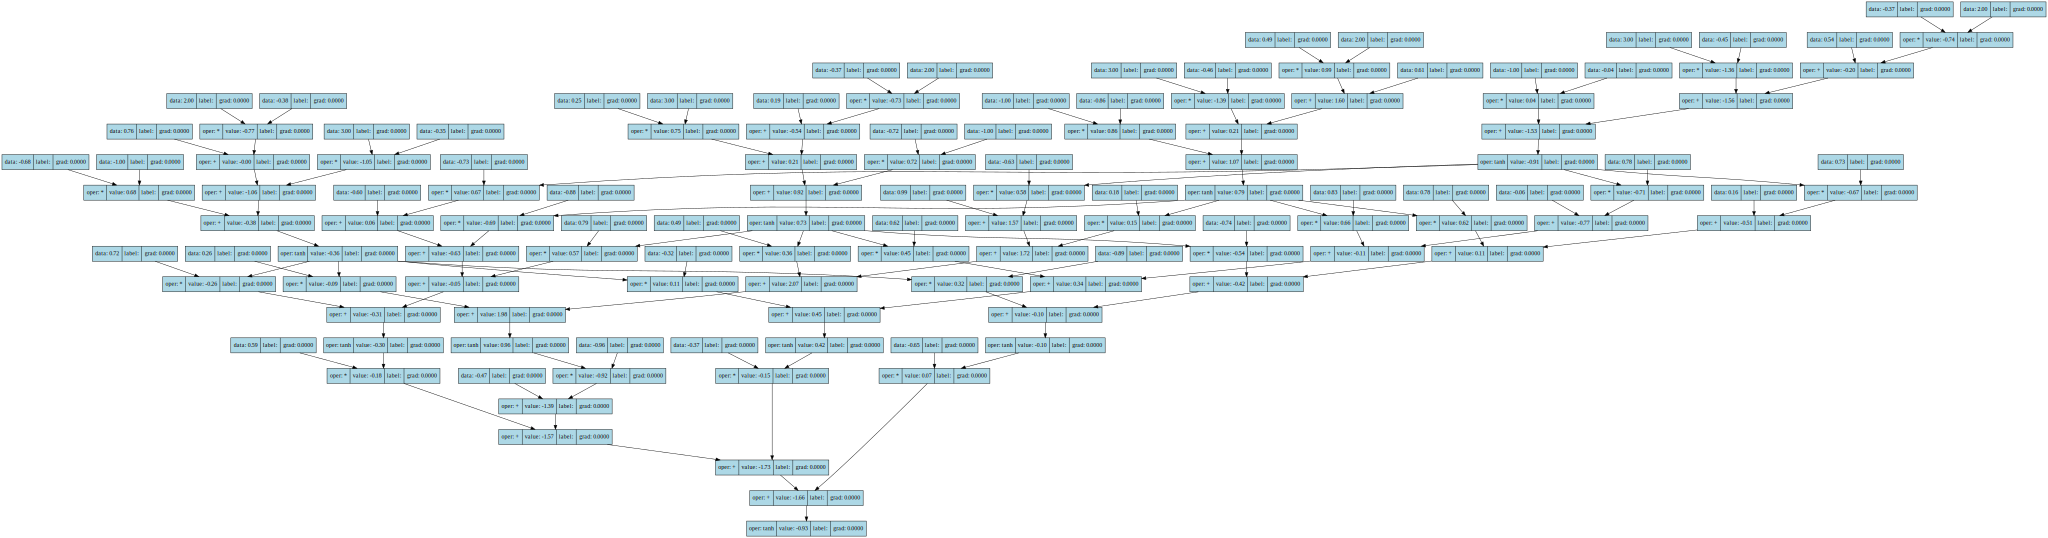

In [ ]:
dot = draw_computation_graph(a(x))
display(dot)

## Getting the number of parameters

In [ ]:
len(a.parameters())

41

## Defining the training data

In [ ]:
# data

xs = [
    [2.0 , 3.1 , 3.4],
    [-1.2 , 2.0 , -1.4],
    [5.0 , 2.1 , 2.9],
    [2.9 , -3.0 , -3.0]
]

ys = [1.0 , -1.0 , 1.0 , -1.0]

## Training the neural network
This cell contains the training loop for the neural network.
 It iterates through epochs, performs forward and backward passes, and updates the model's parameters to minimize the loss.


In [ ]:
losses = []
for epoch in range(30):

  # forward pass
  ypred = [a(x) for x in xs]
  loss = sum((Value(ygt) - yout).pow(2)  for ygt,yout in zip(ys,ypred))

  # backward pass
  for p in a.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in a.parameters():
    p.data += -0.01 * p.grad
  losses.append(loss.data)
  print(f"epoch: {epoch} | loss: {loss.data}")


epoch: 0 | loss: 7.156241132625225
epoch: 1 | loss: 6.879770274777014
epoch: 2 | loss: 6.443141383150094
epoch: 3 | loss: 5.682545282039112
epoch: 4 | loss: 4.333425284486576
epoch: 5 | loss: 2.422762931465994
epoch: 6 | loss: 1.0407517535273267
epoch: 7 | loss: 0.5544398382987474
epoch: 8 | loss: 0.36897688026963416
epoch: 9 | loss: 0.27573984377191973
epoch: 10 | loss: 0.22019116940968383
epoch: 11 | loss: 0.18341821065425454
epoch: 12 | loss: 0.15729247648209768
epoch: 13 | loss: 0.1377720394932931
epoch: 14 | loss: 0.12262754785316902
epoch: 15 | loss: 0.11053075846033411
epoch: 16 | loss: 0.10064170488748674
epoch: 17 | loss: 0.09240341453519019
epoch: 18 | loss: 0.08543203382052383
epoch: 19 | loss: 0.07945441186047275
epoch: 20 | loss: 0.07427085719434527
epoch: 21 | loss: 0.06973197819490572
epoch: 22 | loss: 0.06572376567051387
epoch: 23 | loss: 0.062157688397924446
epoch: 24 | loss: 0.0589639408655753
epoch: 25 | loss: 0.05608673177930997
epoch: 26 | loss: 0.05348092815565791

In [ ]:
ypred = [a(x) for x in xs]
ypred

[Value(data=0.8667160333295363),
 Value(data=-0.9114274000023725),
 Value(data=0.8610491358711013),
 Value(data=-0.9856753286430497)]

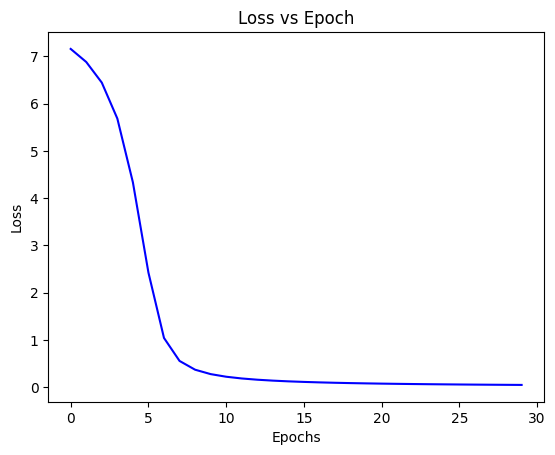

In [ ]:
plt.plot(np.arange(len(losses)) , losses , color='b' )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()